# Notebook looks at fastcam, dimestv, plasma data and erf correction coil waveforms for the shot 192974

## Plasma data

In [1]:
import matplotlib.pyplot as plt
import plot_tools as plot
import read
import numpy as np
import matplotlib.colors 
import process

shot = 192974
sections, labels = read.sections(shot)
fig, ax = plt.subplots(5,1,figsize=(15,20))
ip,t,units = read.one_d(shot,'ip')
plot.plot1d_ax(ax[0],t/1000,ip/1e6,'time [s]',r'I$_p$ [MA]',xlim=[-0.1,7.0])
n,t,units = read.one_d(shot,'density')
plot.plot1d_ax(ax[1],t/1000,n*1e6,'time [s]',r'n$_e$ [m$^{-3}$]',xlim=[-0.1,7.0])
osp,t,units = read.one_d(shot,'rvsod')
plot.plot1d_ax(ax[2],t/1000,osp,'time [s]',r'R$_{OSP}$ [m]',xlim=[-0.1,7.0],ylim=[1.4,1.6],c='steelblue',alpha=1)

plot.show_coils(shot,[ax[3],ax[4]],xlimit=[-0.1,7])

# remove xlables and xticklabels from all but bottom plot
for i in range(len(ax)-1):
    ax[i].set_xlabel('')
    ax[i].set_xticklabels([])

# breakup the x-axis into 9 sections with these times and labels

wforms = process.extract_IC_wforms(shot)
ampl = wforms['PCC']['ampl']
time = wforms['PCC']['time']/1000
# get avg amplitude and std for each section
A, S = [], []
for s in sections:
    A.append(np.mean(ampl[(time>s[0]) & (time<s[1])]))
    S.append(np.std(ampl[(time>s[0]) & (time<s[1])]))
    
# show each section as a vertical band in t with label on all plots
for i,s in enumerate(sections):
    for a in ax:
        a.axvspan(s[0],s[1],color='gray',alpha=0.2)
        # get ylim for each axis
    ylim = ax[3].get_ylim()
    ax[3].text((s[0]+s[1])/2,0.5*ylim[1],labels[i],rotation=90,ha='center',va='center',fontsize=15)


## Show fastcam and dimes tv slices

looking for slc_wforms/192973_PCC.sav


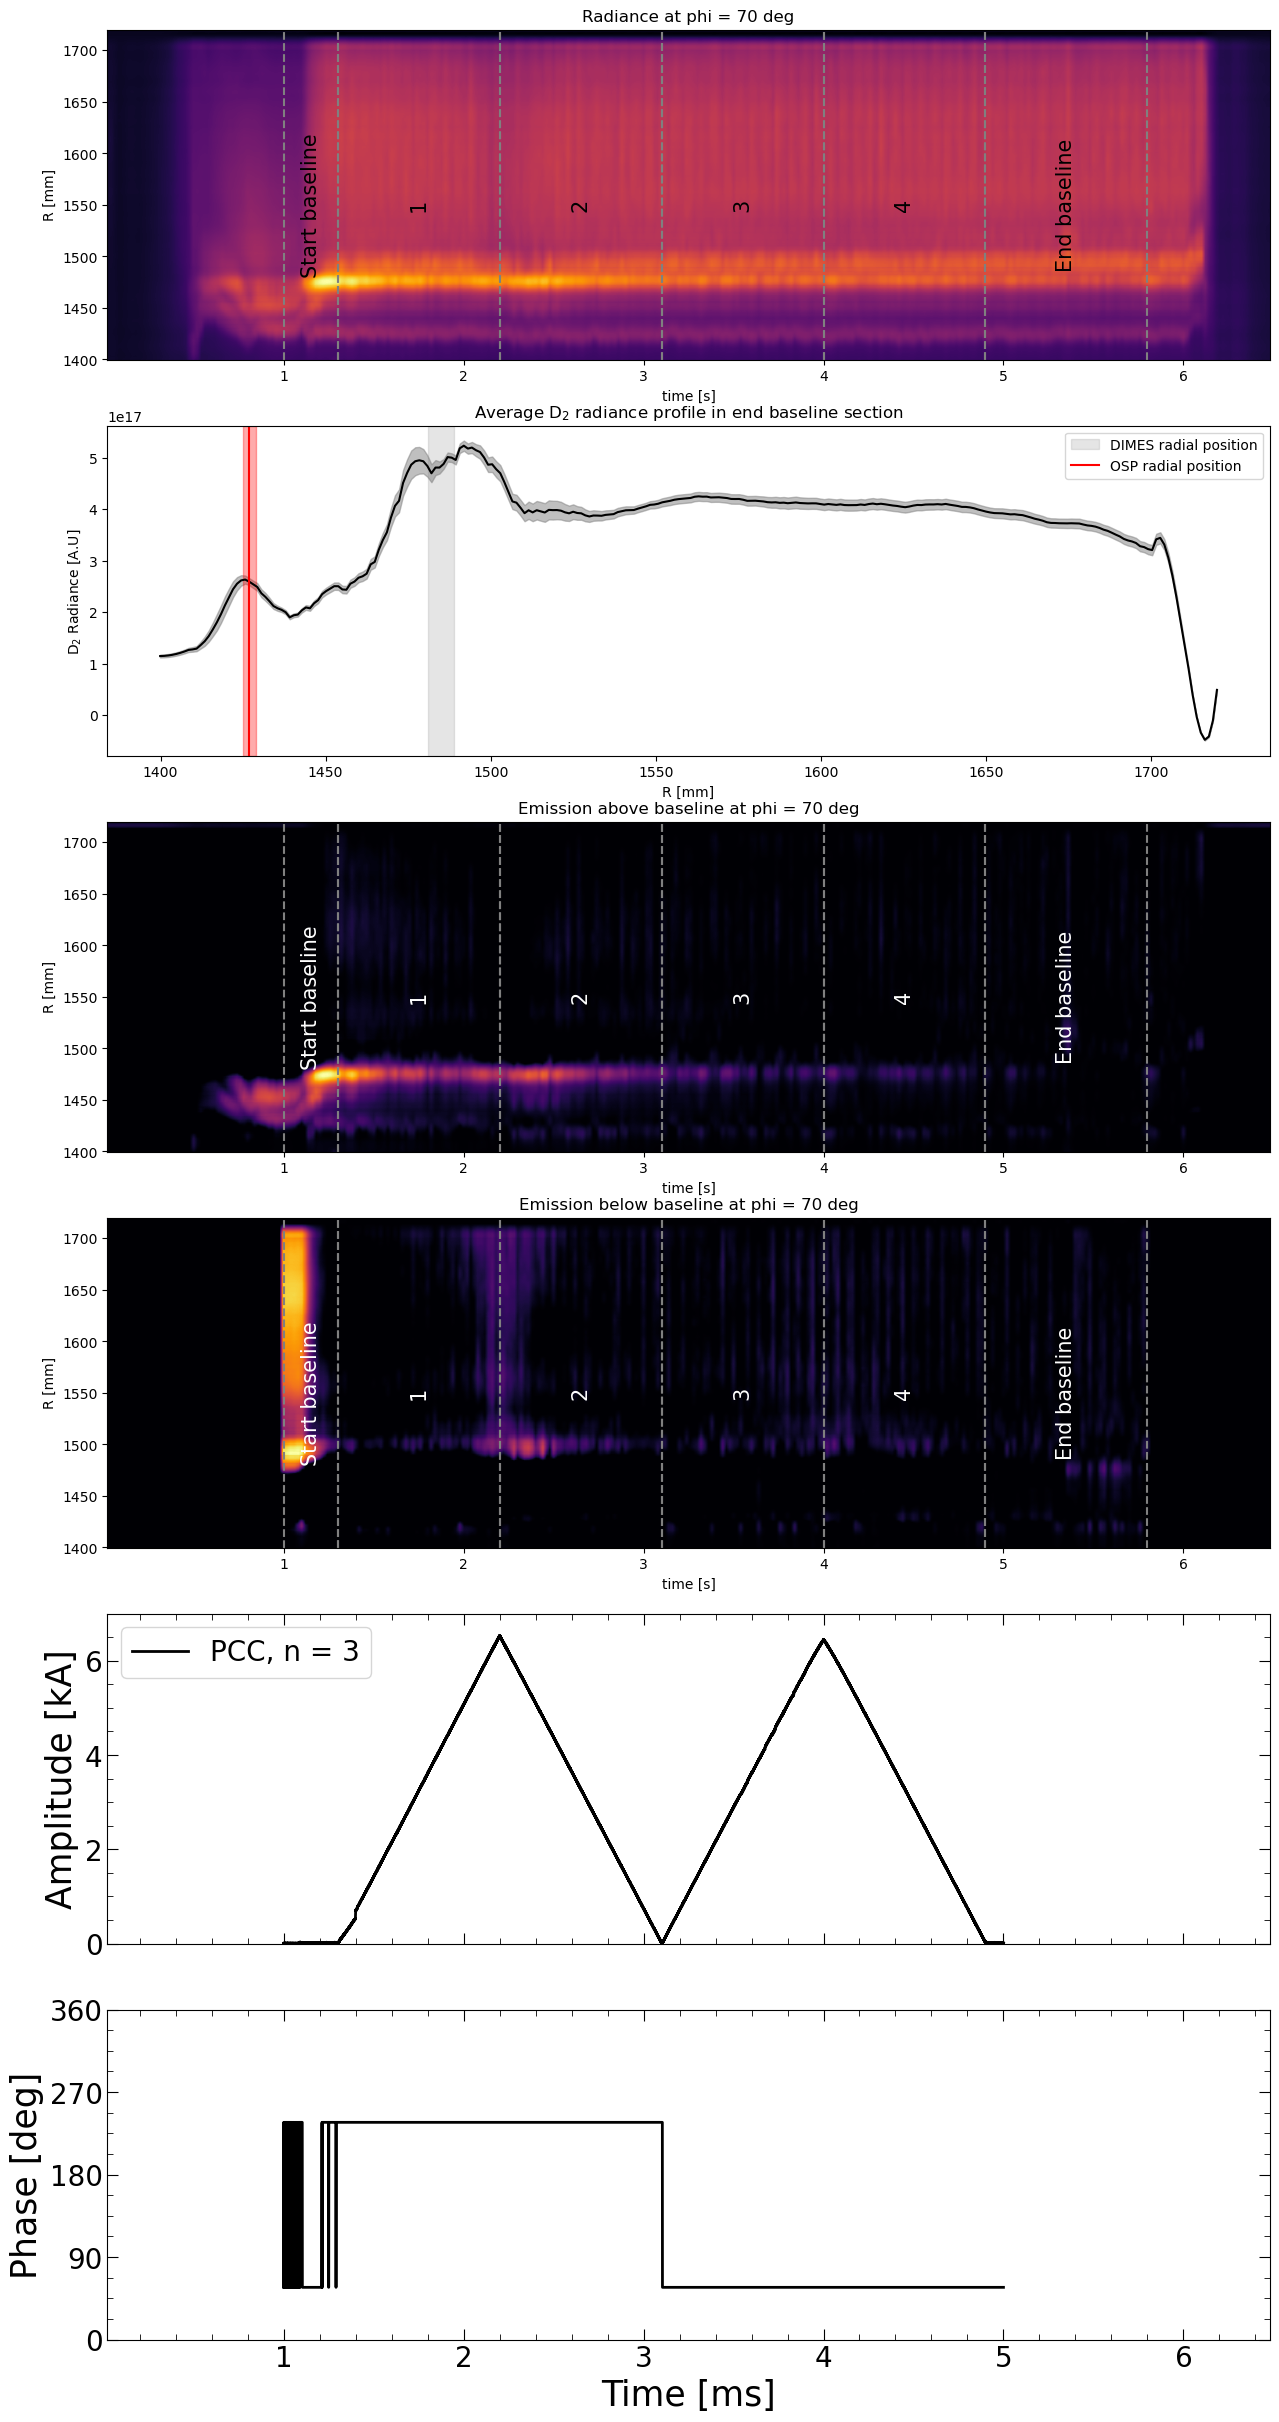

In [ ]:
import read


    
phi = 70
r, t, p, p_f = read.fast_cam_filtered_prof(shot,phi,normalize=False,filt_parm=[15,3])
fig, ax = plt.subplots(6,1,figsize=(15,30))
ax[0].contourf(t,r,p_f,cmap='inferno',levels=1000)
ax[0].set_ylabel('R [mm]')
ax[0].set_xlabel('time [s]')
ax[0].set_title(f'Radiance at phi = {phi} deg')
# show sections with vertical dashed lines
for s,l in zip(sections,labels):
    ax[0].axvline(s[0],c='gray',ls='--')
    ax[0].axvline(s[1],c='gray',ls='--')
    ax[0].text((s[0]+s[1])/2,1550,l,rotation=90,ha='center',va='center',fontsize=15)
    
# average all radial profiles in the end time section and plot as a function of r
base_start = sections[-1][0]
base_end = sections[-1][1]
idx_base_start = np.argmin(np.abs(t[:,0]-base_start))
idx_base_end = np.argmin(np.abs(t[:,0]-base_end))
prof_base = p_f[idx_base_start:idx_base_end,:]
prof_base_avg = np.mean(prof_base,axis=0)
prof_base_std = np.std(prof_base,axis=0)
ax[1].plot(r[0,:],prof_base_avg,c='k')
# plot std as shaded region
ax[1].fill_between(r[0,:],prof_base_avg-prof_base_std,prof_base_avg+prof_base_std,color='gray',alpha=0.5)
# show dimes position as a vertical shaded region between r = 1.485-0.04 and r = 1.485+0.04
ax[1].axvspan(1485-0.04*100,1485+0.04*100,color='gray',alpha=0.2,label='DIMES radial position')
ax[1].set_ylabel(r'D$_2$ Radiance [A.U]')
ax[1].set_xlabel('R [mm]')
ax[1].set_title(r'Average D$_2$ radiance profile in end baseline section')

# also show avg osp in this section
osp,osp_t,units = read.one_d(shot,'rvsod')
osp_t = osp_t/1000
osp_base = osp[(osp_t>base_start) & (osp_t<base_end)]
osp_avg = np.mean(osp_base)*1000
osp_std = np.std(osp_base)*1000
# show as horizontal line with std as shaded region
ax[1].axvline(osp_avg,c='r',label='OSP radial position')
ax[1].axvspan(osp_avg-osp_std,osp_avg+osp_std,color='red',alpha=0.33)

ax[1].legend()

# subtract the baseline from all profiles and show in the third axis 
prof_sub = p_f - prof_base_avg
# replace negative values with 0
prof_sub[prof_sub<0] = 0
ax[2].contourf(t,r,prof_sub,cmap='inferno',levels=1000)

ax[2].set_ylabel('R [mm]')
ax[2].set_xlabel('time [s]')
ax[2].set_title(f'Emission above baseline at phi = {phi} deg')
# show sections with vertical dashed lines
for s,l in zip(sections,labels):
    ax[2].axvline(s[0],c='gray',ls='--')
    ax[2].axvline(s[1],c='gray',ls='--')
    ax[2].text((s[0]+s[1])/2,1550,l,rotation=90,ha='center',va='center',fontsize=15,color='white')
    
# replace positive values with 0
prof_sub = p_f - prof_base_avg
prof_sub[prof_sub>0] = 0
prof_sub = -prof_sub
# set everthing before section 1 and after section 8 to 0
prof_sub[t[:,0]<sections[0][0],:] = 0
prof_sub[t[:,0]>sections[-1][1],:] = 0
ax[3].contourf(t,r,prof_sub,cmap='inferno',levels=1000)
ax[3].set_ylabel('R [mm]')
ax[3].set_xlabel('time [s]')
ax[3].set_title(f'Emission below baseline at phi = {phi} deg')
# show sections with vertical dashed lines
for s,l in zip(sections,labels):
    ax[3].axvline(s[0],c='gray',ls='--')
    ax[3].axvline(s[1],c='gray',ls='--')
    ax[3].text((s[0]+s[1])/2,1550,l,rotation=90,ha='center',va='center',fontsize=15,color='white')
    
plot.show_coils(shot,[ax[4],ax[5]],xlimit=[t[:,0][0],t[:,0][-1]])
    

## Look at profiles over baseline for each phase and how they change with time 

[1.3, 2.2] 1 0
[2.2, 3.1] 2 1
[3.1, 4] 3 2
[4, 4.9] 4 3


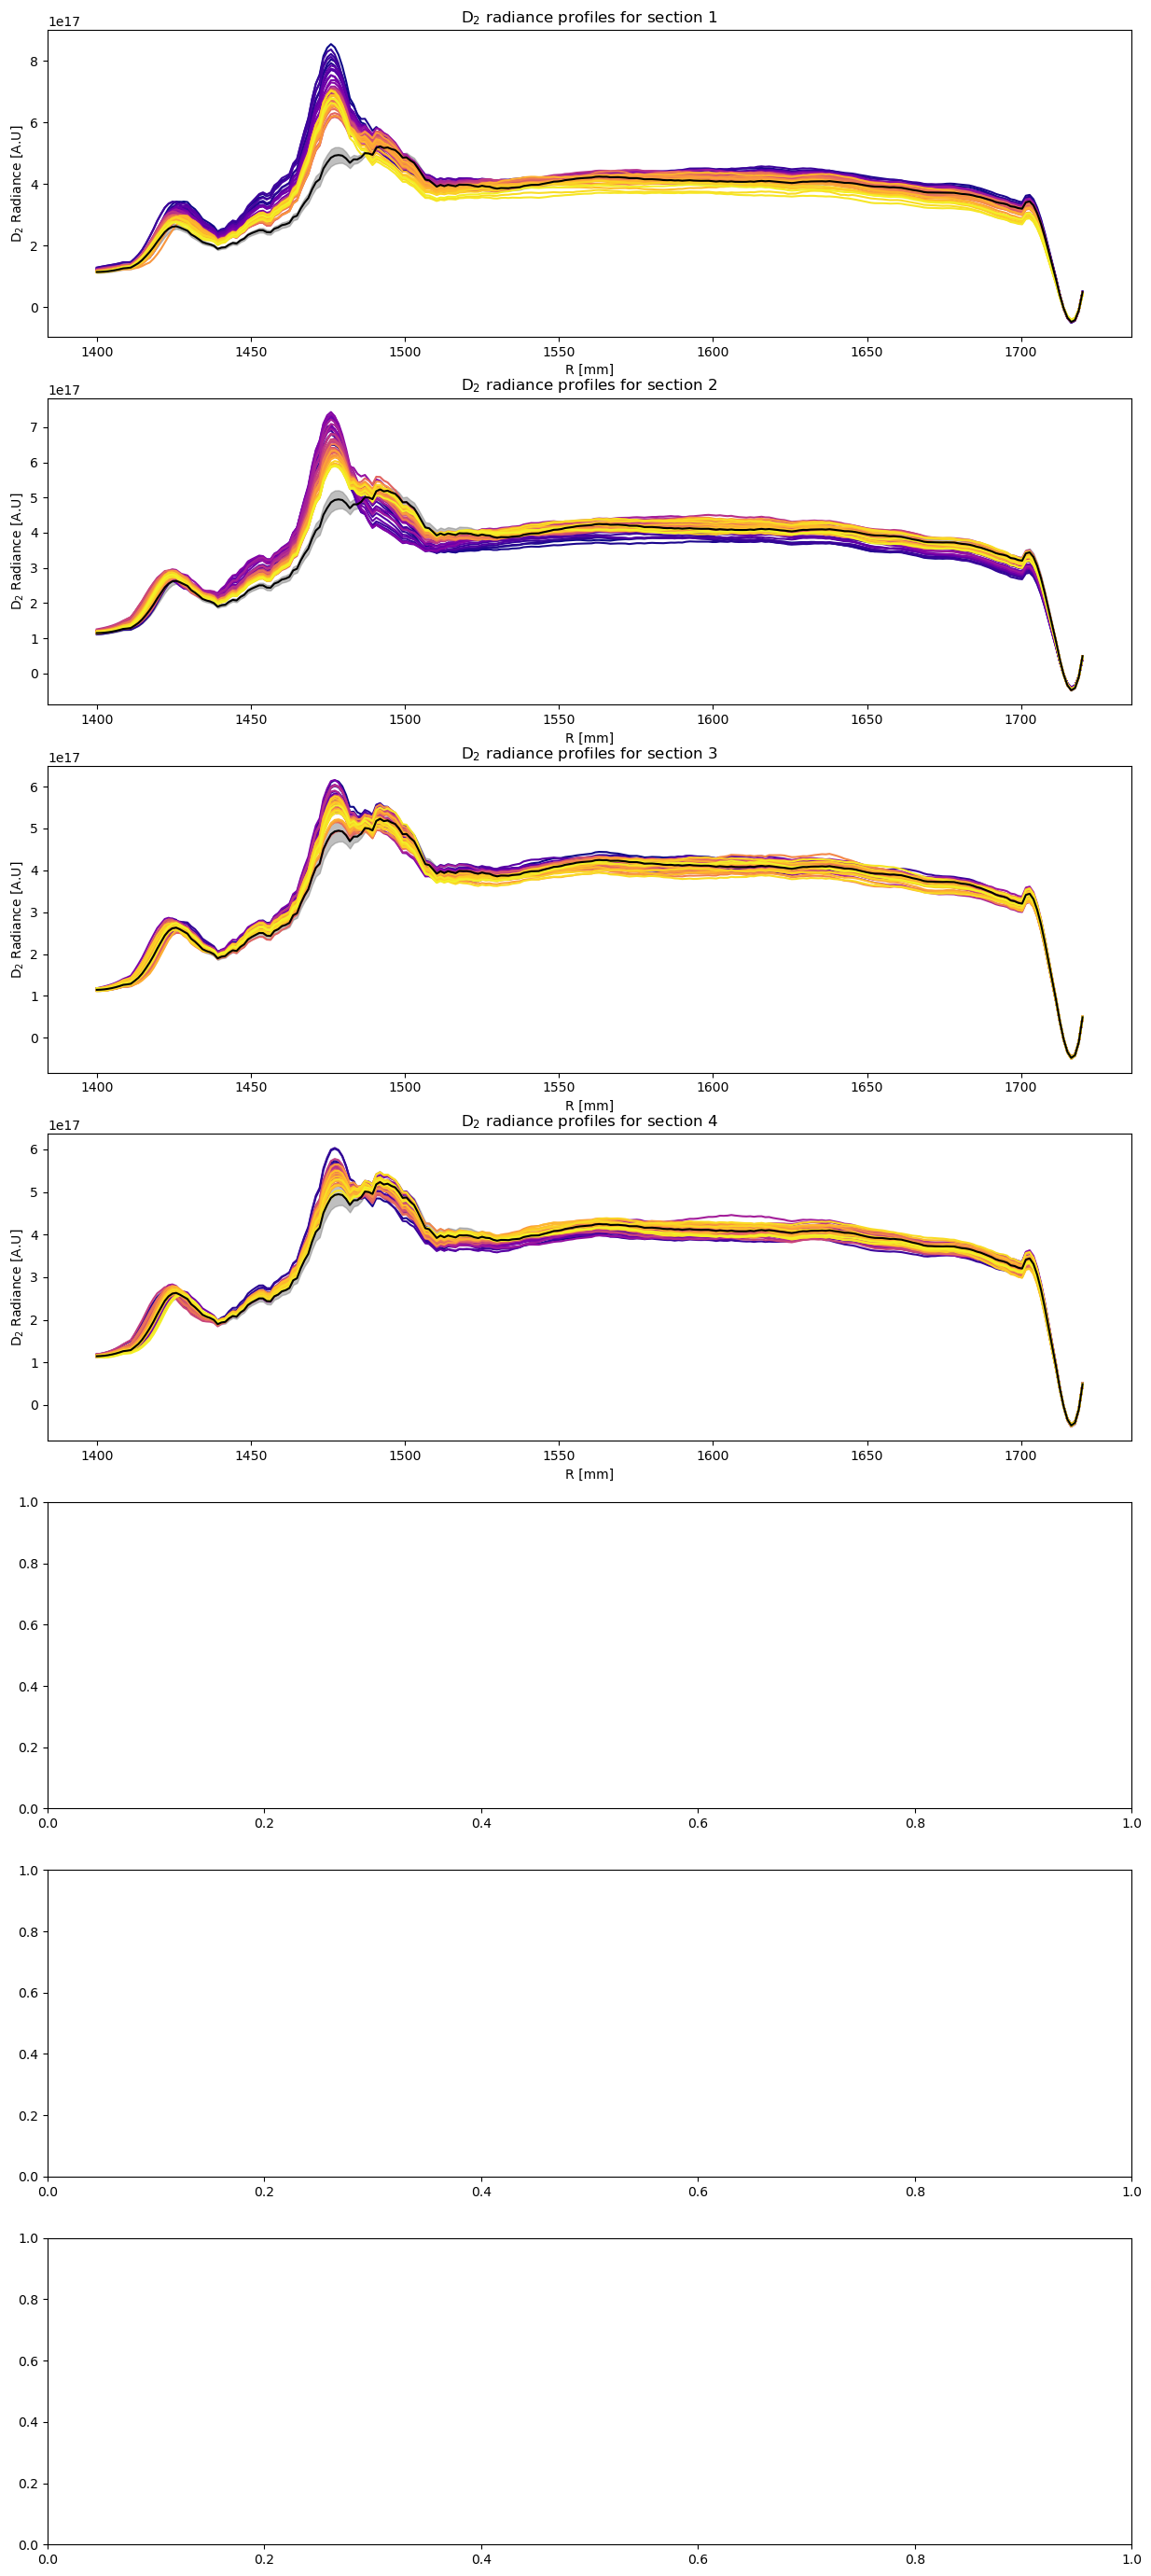

In [ ]:
fig, ax = plt.subplots(7,1,figsize=(15,35))
r, t, p, p_f = read.fast_cam_filtered_prof(shot,phi,normalize=False,filt_parm=[15,3])
k = 0
for s,l in zip(sections,labels):
    if l not in ['Start baseline', 'End baseline']:
        print(s,l,k)
        start = s[0]
        end = s[1]
        idx_start = np.argmin(np.abs(t[:,0]-start))
        idx_end = np.argmin(np.abs(t[:,0]-end))
        profiles = p_f[idx_start:idx_end,:]
        # plot each profile but change color based on time
        for i in range(profiles.shape[0]):
            ax[k].plot(r[0,:],profiles[i,:],c=plt.cm.plasma(i/profiles.shape[0]))
        ax[k].set_ylabel(r'D$_2$ Radiance [A.U]')
        ax[k].set_xlabel('R [mm]')
        ax[k].set_title(f'D$_2$ radiance profiles for section {l}')
        ax[k].plot(r[0,:],prof_base_avg,c='k')
        # plot std as shaded region
        ax[k].fill_between(r[0,:],prof_base_avg-prof_base_std,prof_base_avg+prof_base_std,color='gray',alpha=0.5)
        k = k + 1
        

In [ ]:
np.log(np.min(prof_sub))

-inf

In [ ]:
r[0,:]

array([1399.8637138 , 1401.09028961, 1402.31686542, 1403.54344123,
       1404.77001704, 1405.99659284, 1407.22316865, 1408.44974446,
       1409.67632027, 1410.90289608, 1412.12947189, 1413.3560477 ,
       1414.58262351, 1415.80919932, 1417.03577513, 1418.26235094,
       1419.48892675, 1420.71550256, 1421.94207836, 1423.16865417,
       1424.39522998, 1425.62180579, 1426.8483816 , 1428.07495741,
       1429.30153322, 1430.52810903, 1431.75468484, 1432.98126065,
       1434.20783646, 1435.43441227, 1436.66098807, 1437.88756388,
       1439.11413969, 1440.3407155 , 1441.56729131, 1442.79386712,
       1444.02044293, 1445.24701874, 1446.47359455, 1447.70017036,
       1448.92674617, 1450.15332198, 1451.37989779, 1452.60647359,
       1453.8330494 , 1455.05962521, 1456.28620102, 1457.51277683,
       1458.73935264, 1459.96592845, 1461.19250426, 1462.41908007,
       1463.64565588, 1464.87223169, 1466.0988075 , 1467.3253833 ,
       1468.55195911, 1469.77853492, 1471.00511073, 1472.23168

In [ ]:
sections

[[1, 1.3], [1.3, 2.2], [2.2, 3.1], [3.1, 4], [4, 4.9], [4.9, 5.8]]